In [397]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np

# Цели и задачи проекта
Цель аналитическая: 
- отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.  

Задачи: 
- определиться с параметрами будущей модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы при помощи разведывательного анализа данных;  
- отчёт по результатам анализа.

Цель учебная:
- изучить методы выявления и работы с отсутствющими значениями и выбросами

## исходные данные

In [398]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

stud = pd.read_csv('C:/Users/зщш/0.1.9.anaconda/modul_2/stud_math.csv')
stud.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


## Первичный анализ данных

In [399]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Датафрейм содержит 395 строк и 30 столбцов, из них 13 числовых, 17 текстовых.  
Многие столбцы содержат нулевые значения, больше всего   Pstatus, Fjob, famsup, paid 

In [400]:
z = stud.isnull().sum(axis=1).sort_values() 
stud = stud[z != 6]
stud.isnull().sum(axis=1).sort_values()

<ipython-input-400-eeb313ab948e>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stud = stud[z != 6]


205    0
187    0
188    0
100    0
343    0
      ..
227    5
268    5
313    5
280    5
54     5
Length: 393, dtype: int64

Максимальное количество неизвестных данных в 1 строке 6 значений (20%), таких строк в датафрейме 2 удалили их. 

После преобразования в исходных данных осталось 393 строки.

In [401]:
stud[stud.duplicated() == True]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score


Наличие дублирующих значений не выявлено.

### 1. school (аббревиатура школы, в которой учится ученик)

In [402]:
print(stud.school.nunique())
display(round(pd.DataFrame(stud.school.value_counts(normalize=True)), 2))

2


,school
GP,0.88
MS,0.12


В анализируемых данных ученики из 2 школ - GP (основная масса, 88%), MS (всего около 12% учеников). Причиной может быть то, что MS сама по себе меньше, чем GP.  
Пропущенные и нулевые значения отсутствуют.

### 2. sex (пол ученика ('F' - женский, 'M' - мужской))

In [403]:
display(pd.DataFrame(stud.sex.value_counts(normalize=True)))
round((stud.groupby(['school'])['sex'].value_counts(normalize=True)), 2)

,sex
F,0.526718
M,0.473282


school  sex
GP      F      0.52
        M      0.48
MS      F      0.54
        M      0.46
Name: sex, dtype: float64

Распределение по гендорному признаку примерно равное - 53% девочек и 47% мальчиков в целом. Пропорция примерно сохраняется и внутри школ.  
Пропущенные и нулевые значения отсутствуют.

### 3. age  (возраст ученика (от 15 до 22))

,age
16,103
17,97
18,82
15,82
19,24
20,3
22,1
21,1


Text(0.5, 1.0, 'Распределение учеников по возрастам')

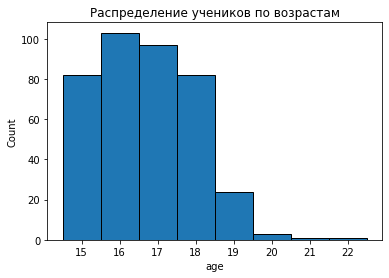

In [404]:
display(pd.DataFrame(stud.age.value_counts()))

plt.bar(stud['age'].value_counts().index, 
        stud['age'].value_counts().values,
         fill = 'navy', edgecolor = 'k', width = 1)
plt.xlabel('age'); plt.ylabel('Count'); plt.title('Распределение учеников по возрастам')

In [405]:
value = stud.age
IQR = value.quantile(0.75) - value.quantile(0.25)
perc25 = value.quantile(0.25)
perc75 = value.quantile(0.75)

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


Пропущенные и нулевые значения отсутствуют.    
Возраст старше 20 лет является нетипичным значенеим и может быть удален как выброс.

In [406]:
stud_age_negative = stud[stud['age'] > 20]
stud = stud.drop(stud_age_negative.index, axis=0)

stud.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 394
Columns: 30 entries, school to score
dtypes: float64(12), int64(1), object(17)
memory usage: 94.7+ KB


После удаления выбросов датафрейм содержит 391 строку.

In [407]:
stud.groupby(['school'])['age'].value_counts()

school  age
GP      16     103
        17      85
        15      82
        18      57
        19      18
        20       1
MS      18      25
        17      12
        19       6
        20       2
Name: age, dtype: int64

В школе MS учатся ученики с 17 лет, из чего можно сделать вывод, что это старшая школа, это объясняет меньшее количество учащихся в ней.

### 4. address (тип адреса ученика ('U' - городской, 'R' - за городом))

,address
U,292
R,82
NaN,17


Text(0.5, 1.0, 'Распределение учеников по месту жительства')

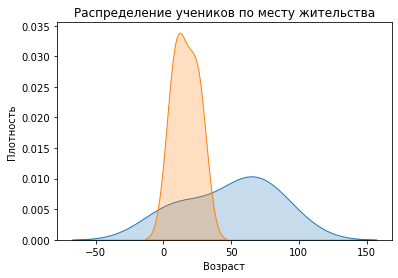

In [408]:
display(pd.DataFrame(stud.address.value_counts(dropna=False)))

data = stud.loc[stud['address'] == 'U'].age.value_counts()
data2 = stud.loc[stud['address'] == 'R'].age.value_counts()

sns.kdeplot(data,  label = 'Городской', shade = True)
sns.kdeplot(data2, label = 'За городом', shade = True)
plt.xlabel('Возраст'); plt.ylabel('Плотность'); plt.title('Распределение учеников по месту жительства')

In [409]:
round((stud.groupby(['school'])['address'].value_counts(
    normalize=True, dropna=False)), 2)

school  address
GP      U          0.79
        R          0.17
        NaN        0.03
MS      R          0.49
        U          0.40
        NaN        0.11
Name: address, dtype: float64

In [410]:
Pst_ad_GP = 'U'
stud.address = np.where((stud.school == 'GP') & (stud.address.isnull()),
                        Pst_ad_GP,
                        stud.address)

Pst_ad_MS = 'R'
stud.address = np.where((stud.school == 'MS') & (stud.address.isnull()),
                        Pst_ad_MS,
                        stud.address)

In [411]:
round((stud.groupby(['sex'])['address'].value_counts(
    normalize=True, dropna=False)), 2)

sex  address
F    U          0.77
     R          0.23
M    U          0.78
     R          0.22
Name: address, dtype: float64

Адреса содержат пропуски - общее количество 16, в том числе для школы GP они составляют 3%, для MS  - 11%. Заменим их соответствующими модальными значениями.   
Ученики GP в большей степени живут в городе (79%), ученики  MS  в большей степени живут за городом (49%).  
Распределение учеников живущих в городе и за его пределами по гендерному признаку идентичное.  

### 5. famsize (размер семьи('LE3' <= 3, 'GT3' >3))

In [412]:
pd.DataFrame(stud.famsize.value_counts(dropna=False))

,famsize
GT3,257
LE3,107
NaN,27


В большинстве семей учеников больше одного ребенка.  
Количество неизвестных значений 27.

In [413]:
mode_fs = stud.famsize.mode()[0]
stud.famsize = stud.famsize.apply(
    lambda x: mode_fs if pd.isnull(x) else x)

pd.DataFrame(stud.famsize.value_counts(dropna=False))

,famsize
GT3,284
LE3,107


### 6. Pstatus (статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно))

In [414]:
pd.DataFrame(stud.Pstatus.value_counts(dropna=False))

,Pstatus
T,312
NaN,43
A,36


In [415]:
round((stud.groupby(['famsize'])['Pstatus'].value_counts(
    normalize=True, dropna=False)), 2)

famsize  Pstatus
GT3      T          0.81
         NaN        0.11
         A          0.08
LE3      T          0.76
         NaN        0.12
         A          0.12
Name: Pstatus, dtype: float64

In [416]:
Pst_mode = stud.Pstatus.mode()[0]
stud.Pstatus = np.where(stud.Pstatus.isnull(),
                        Pst_mode,
                        stud.Pstatus)

display(round((stud.Pstatus.value_counts(normalize=True, dropna=False)), 2))

T    0.91
A    0.09
Name: Pstatus, dtype: float64

Отсутствующие значения заменены на модальные. 

### 7. Medu (образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее))

In [417]:
pd.DataFrame(stud.Medu.value_counts(dropna=False))

,Medu
4.0,131
2.0,101
3.0,95
1.0,58
0.0,3
NaN,3


У большинства учеников матери имеют высшее образование, вторым по рейтингу является образование старшей школы.   
Отсутствующие значения имеют не значительный удельны вес, заменим их на модальные.

In [418]:
stud = stud.copy()

mode_Medu = stud.Medu.mode()[0]
stud.Medu = stud.Medu.apply(
    lambda x: mode_Medu if pd.isnull(x) else x)
pd.DataFrame(stud.Medu.value_counts(dropna=False))

,Medu
4.0,134
2.0,101
3.0,95
1.0,58
0.0,3


In [419]:
value = stud.Medu
IQR = value.quantile(0.75) - value.quantile(0.25)
perc25 = value.quantile(0.25)
perc75 = value.quantile(0.75)

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


### 8. Fedu (образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее))

In [420]:
pd.DataFrame(stud.Fedu.value_counts(dropna=False))

,Fedu
2.0,105
3.0,96
4.0,88
1.0,75
NaN,24
0.0,2
40.0,1


Столбец с распределением образования отцов имеет существенные пропуски, 1 строку с ошибкой.  
Ошибочное значение заменим, т.к. там присутствует опечатка. Отсутствующие значения заменим модальными. 


In [421]:
stud = stud.copy()

mode_Fedu_GT3 = 3.0
stud.Fedu = np.where((stud.famsize == 'GT3') & (stud.Fedu.isnull()),
                          mode_Fedu_GT3,
                          stud.Fedu)
mode_Fedu_LE3 = 2.0
stud.Fedu = np.where((stud.famsize == 'LE3') & (stud.Fedu.isnull()),
                          mode_Fedu_LE3,
                          stud.Fedu)

stud.Fedu = stud.Fedu.astype(str).apply(
    lambda x: 4.0 if x.strip() == '40.0' else x)

round((stud.groupby(['famsize'])['Fedu'].value_counts(dropna=False)), 2)

famsize  Fedu
GT3      3.0     91
         2.0     72
         4.0     67
         1.0     51
         0.0      2
         4.0      1
LE3      2.0     40
         1.0     24
         3.0     22
         4.0     21
Name: Fedu, dtype: int64

В семьях, где более 3 членов семьи, у отцов преобладает образование среднее специальное или 11 классов.  
В семьях, где менее 3 членов семьи, у отцов в большей степени отсутствует проф образование.


### 9. Mjob (работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое))

In [422]:
display(round((stud.Mjob.value_counts(normalize=True, dropna=False)), 2))

other       0.34
services    0.25
at_home     0.15
teacher     0.14
health      0.08
NaN         0.05
Name: Mjob, dtype: float64

Пропущенные значения составляют 5%, заменим их модальными.  
Наибольшую группу составляют "прочие" профессии матерей, из детализированных значений преобладает гос служба.

<AxesSubplot:>

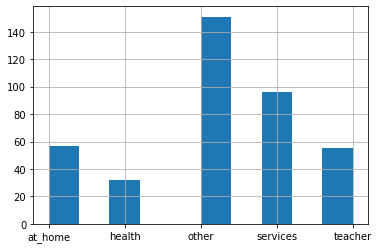

In [423]:
stud = stud.copy()

mode_Mj = stud.Mjob.mode()[0]
stud.Mjob = stud.Mjob.apply(
    lambda x: mode_Mj if pd.isnull(x) else x)

stud.Mjob.hist()

### 10. Fjob (работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое))

other       0.50
services    0.26
NaN         0.09
teacher     0.07
at_home     0.04
health      0.04
Name: Fjob, dtype: float64

<AxesSubplot:>

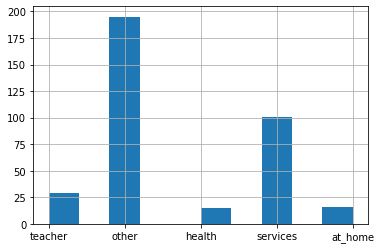

In [424]:
display(round((stud.Fjob.value_counts(normalize=True, dropna=False)), 2))
stud.Fjob.hist()

Пропущенные значения составляют 9%.  
Половину значений составляют "прочие" профессии отцов, из детализированных значений преобладает гос служба.

<AxesSubplot:xlabel='Mjob,Fjob'>

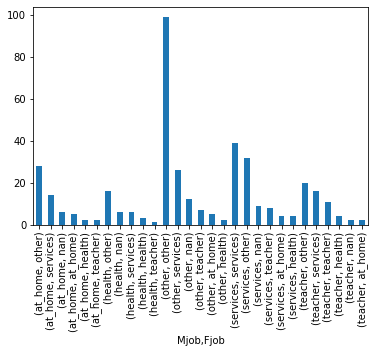

In [425]:
stud.groupby(['Mjob'])['Fjob'].value_counts(dropna=False).plot(kind='bar')

При парном рассмотрении семей, наибольшую группу составляют семьи, где оба родителя трудятся в "прочих" отраслях, а так же семьи гос служащих.

In [426]:
stud.groupby(['Mjob'])['Fjob'].value_counts(dropna=False)

Mjob      Fjob    
at_home   other       28
          services    14
          NaN          6
          at_home      5
          health       2
          teacher      2
health    other       16
          NaN          6
          services     6
          health       3
          teacher      1
other     other       99
          services    26
          NaN         12
          teacher      7
          at_home      5
          health       2
services  services    39
          other       32
          NaN          9
          teacher      8
          at_home      4
          health       4
teacher   other       20
          services    16
          teacher     11
          health       4
          NaN          2
          at_home      2
Name: Fjob, dtype: int64

In [427]:
stud = stud.copy()

mode_Fj_services = 'services'
stud.Fjob = np.where((stud.Mjob == 'services') & (stud.Fjob.isnull()),
                     mode_Fj_services,
                     stud.Fjob)
mode_Fj = 'other'
stud.Fjob = stud.Fjob.apply(
    lambda x: mode_Fj if pd.isnull(x) else x)

display(round((stud.Fjob.value_counts(normalize=True, dropna=False)), 2))

other       0.57
services    0.28
teacher     0.07
at_home     0.04
health      0.04
Name: Fjob, dtype: float64


После замены отсутствующих значений общая тенденция не изменилась.

### 11. reason (причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое))

In [428]:
display(round((stud.reason.value_counts(normalize=True, dropna=False)), 2))

course        0.35
home          0.27
reputation    0.26
other         0.08
NaN           0.04
Name: reason, dtype: float64

Пропущенные значения составляют 4%.  
Основной фактор выбора школы - образовательная программа (35%). Репутация школы и близость к дому составляют 26%. Процент остальных причин не значителен и составляет 8%.

In [429]:
mode_reason = stud.reason.mode()[0]
stud.reason = stud.reason.apply(
    lambda x: mode_reason if pd.isnull(x) else x)

display(round((stud.reason.value_counts(normalize=True, dropna=False)), 2))

course        0.39
home          0.27
reputation    0.26
other         0.08
Name: reason, dtype: float64

### 12. guardian (опекун ('mother' - мать, 'father' - отец, 'other' - другое))

In [430]:
display(round((stud.guardian.value_counts(normalize=True, dropna=False)), 2))

mother    0.63
father    0.22
NaN       0.08
other     0.07
Name: guardian, dtype: float64

У большинства учеников (64%) опекуном является мать, или отец (22%). Другие варианты занимают незначительную долю (7%).  
Пропущенные значения составляют 7%.

In [431]:
mode_guardian = stud.guardian.mode()[0]
stud.guardian = stud.guardian.apply(
    lambda x: mode_guardian if pd.isnull(x) else x)

display(round((stud.guardian.value_counts(normalize=True, dropna=False)), 2))

mother    0.71
father    0.22
other     0.07
Name: guardian, dtype: float64

### 13. traveltime (время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.))

In [432]:
display(round((stud. traveltime.value_counts(normalize=True, dropna=False)), 2))

1.0    0.61
2.0    0.25
NaN    0.07
3.0    0.06
4.0    0.02
Name: traveltime, dtype: float64

In [433]:
round((stud.groupby(['address'])['traveltime'].value_counts(
    normalize=True, dropna=False)), 2)

address  traveltime
R        1.0           0.38
         2.0           0.33
         3.0           0.15
         NaN           0.09
         4.0           0.05
U        1.0           0.68
         2.0           0.22
         NaN           0.06
         3.0           0.03
         4.0           0.01
Name: traveltime, dtype: float64

Большинство учеников, даже живущих за городом тратят на дорогу до школы менее 15 минут (40% за городом, 68 % городских).  
До получаса тратят на дорогу 32% учеников, живущих за городом и 22 % городских учеников.  
В значительной удаленности от города (более получаса пути) живут 20% учеников, живущих за городом и 4% городских.  
Отсутствующие значения составляют 7% общего числа данных.  

In [434]:
a = stud[stud.address == 'R'].traveltime.mode()
print(f' мода для R = {a}')
b = stud[stud.address == 'U'].traveltime.mode()
print(f' мода для R = {b}')

 мода для R = 0    1.0
dtype: float64
 мода для R = 0    1.0
dtype: float64


In [435]:
trav_mode = stud.traveltime.mode()[0]
stud.traveltime = np.where(stud.traveltime.isnull(),
                           trav_mode,
                           stud.traveltime)

round((stud.groupby(['address'])['traveltime'].value_counts(
    normalize=True, dropna=False)), 2)

address  traveltime
R        1.0           0.47
         2.0           0.33
         3.0           0.15
         4.0           0.05
U        1.0           0.74
         2.0           0.22
         3.0           0.03
         4.0           0.01
Name: traveltime, dtype: float64

Поскольку отсутствующих значений в данных менее 10%, а модальное значение высокое (более 50%), такие значения были заменены на модальные.

### 14. studytime (время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов))

In [436]:
display(display(round((stud.studytime.value_counts(dropna=False)), 2)))

display(round((stud.groupby(['school'])['studytime'].value_counts(
    normalize=True, dropna=False)), 2))

2.0    194
1.0    101
3.0     64
4.0     27
NaN      5
Name: studytime, dtype: int64

None

school  studytime
GP      2.0          0.50
        1.0          0.25
        3.0          0.16
        4.0          0.08
        NaN          0.01
MS      2.0          0.49
        1.0          0.33
        3.0          0.18
Name: studytime, dtype: float64

Большинство учеников (49%) занимаются вне школы от 2 до 2,5 часов, на втором месте занятия до 2 часов (26%).  
Отсутствующих значений 1%, все относятся к школе GP.
При этом 27 учеников (8%) тратят на занятия вне школы более 10 часов. 

In [437]:
sttime_mode = stud.studytime.mode()[0]
stud.studytime = np.where((stud.school == 'GP') & (stud.studytime.isnull()),
                          sttime_mode,
                          stud.studytime)

display(round((stud.groupby(['school'])['studytime'].value_counts(
    normalize=True, dropna=False)), 2))

school  studytime
GP      2.0          0.51
        1.0          0.25
        3.0          0.16
        4.0          0.08
MS      2.0          0.49
        1.0          0.33
        3.0          0.18
Name: studytime, dtype: float64

Поскольку отсутствующих значений в данных менее 10%, а модальное значение высокое (около 50%), такие значения были заменены на модальные.  
Данный показатель может оказать влияние на предсказываемую величину.  
данные не содержат выбросов.


### 15. failures (количество внеучебных неудач (n, если 1<=n<=3, иначе 0))

In [438]:
display(round((stud.failures.value_counts(dropna=False)), 2))

0.0    292
1.0     48
NaN     22
2.0     16
3.0     13
Name: failures, dtype: int64

У  большенства учеников либо нет поражений в соревнованиях, олимпиадах, и т.п. вне школы, либо их более 3.
При этом отсутствие поражений может свидетельствовать как о победах, так и об отсутствии участия в таких мероприятиях.  
Отсутствующих значений 22 или 6%.  Данные не содержат выбросов.  
Из ранжированных поражений максимальное количество - 1 поражение, 2 и 3 поражения имеют практически равный вес. 
Данный показатель может оказать влияние на предсказываемую величину.  

***как разграничить учеников, которые не проигрывали и которые не участвовали?***

In [439]:
mode_fr = stud.failures.mode()[0]
stud.failures = stud.failures.apply(
    lambda x: mode_fr if pd.isnull(x) else x)

display(round((stud.failures.value_counts(dropna=False)), 2))

0.0    314
1.0     48
2.0     16
3.0     13
Name: failures, dtype: int64

### 16. schoolsup  (дополнительная образовательная поддержка (yes или no))

In [440]:
display(round((stud.schoolsup.value_counts(normalize=True, dropna=False)), 2))

no     0.85
yes    0.13
NaN    0.02
Name: schoolsup, dtype: float64

Услугами репетиторов пользуются только 13% учеников.  
Отсутствующих значений 2%.

In [441]:
sup_mode = stud.schoolsup.mode()[0]

stud.schoolsup = np.where((stud.schoolsup.isnull()),
                          sup_mode,
                          stud.schoolsup)

display(round((stud.schoolsup.value_counts(normalize=True, dropna=False)), 2))

no     0.87
yes    0.13
Name: schoolsup, dtype: float64

Поскольку отсутствующих значений в данных менее 10%, а модальное значение высокое (,jktt 50%), такие значения были заменены на модальные.

### 17. famsup (семейная образовательная поддержка (yes или no))

In [442]:
display(round((stud.famsup.value_counts(normalize=True, dropna=False)), 2))

yes    0.56
no     0.34
NaN    0.10
Name: famsup, dtype: float64

Семейная образовательная поддержка присутствует у 55% учеников.  
Количество отсутствующих значений 10%, по-этому заменять их просто константой не стоит.

In [443]:
display(round((stud.groupby(['school'])['famsup'].value_counts(
    normalize=True, dropna=False)), 2))

school  famsup
GP      yes       0.58
        no        0.31
        NaN       0.11
MS      no        0.60
        yes       0.38
        NaN       0.02
Name: famsup, dtype: float64

In [444]:
mode_famsup_GP = 'yes'
stud.famsup = np.where((stud.school == 'GP') & (stud.famsup.isnull()),
                          mode_famsup_GP,
                          stud.famsup)

mode_famsup_MS = 'no'
stud.famsup = np.where((stud.school == 'MS') & (stud.famsup.isnull()),
                          mode_famsup_MS,
                          stud.famsup)

display(round((stud.groupby(['school'])['famsup'].value_counts(
    normalize=True, dropna=False)), 2))

school  famsup
GP      yes       0.69
        no        0.31
MS      no        0.62
        yes       0.38
Name: famsup, dtype: float64

### 18. paid ( дополнительные платные занятия по математике (yes или no))

In [445]:
display(round((stud.paid.value_counts(dropna=False)), 2))

no     197
yes    154
NaN     40
Name: paid, dtype: int64

Большинство учеников (51%) не занимаются дополнительно платно математикой.  
Отсутствующих значений 10%, по-этому его не корректно просто заменить на одну константу.  
Данный показатель может оказать влияние на предсказываемую величину.

In [446]:
stud.groupby(['studytime'])['paid'].value_counts(
    normalize=True, dropna=False)

studytime  paid
1.0        no      0.643564
           yes     0.217822
           NaN     0.138614
2.0        no      0.462312
           yes     0.427136
           NaN     0.110553
3.0        yes     0.500000
           no      0.453125
           NaN     0.046875
4.0        yes     0.555556
           no      0.407407
           NaN     0.037037
Name: paid, dtype: float64

Распределение по количеству дополнительного времени на зантия показывает, что у учеников которые тратят на доп занятия до 2,5 часов чаще всего нет дополнительных платных занятий по математике, а у учеников которые тратят на доп занятия более 2,5 часов чаще всего есть доп планая математика. Заменим пропуски используя данные модальные значения.

In [447]:
stud = stud.copy()
paid_mode_1 = stud.paid.mode()[0]

stud.paid = np.where(((stud.studytime == 1.0) | (stud.studytime == 2.0)) & (stud.paid.isnull()),
                     paid_mode_1,
                     stud.paid)

stud.paid = stud.paid.apply(lambda x: 'yes' if pd.isnull(x) else x)

display(round((stud.groupby(['studytime'])['paid'].value_counts(
    normalize=True, dropna=False)), 2))

studytime  paid
1.0        no      0.78
           yes     0.22
2.0        no      0.57
           yes     0.43
3.0        yes     0.55
           no      0.45
4.0        yes     0.59
           no      0.41
Name: paid, dtype: float64

In [448]:
display(round((stud.paid.value_counts(normalize=True, dropna=False)), 3))

no     0.596
yes    0.404
Name: paid, dtype: float64

Поскольку данный показатель важен для построения будующей модели, заменили в нем пропущенные значения на модальные в соответствии с распределением по общему времени на доп занятия. Общий тренд не изменился - у большинства учеников нет дополнительных платных занятий по математике.

### 19. activities (дополнительные внеучебные занятия (yes или no))

In [449]:
display(round((stud.activities.value_counts(normalize=True, dropna=False)), 2))

yes    0.49
no     0.47
NaN    0.04
Name: activities, dtype: float64

In [450]:
stud.groupby(['studytime'])['activities'].value_counts(
    normalize=True, dropna=False)

studytime  activities
1.0        no            0.524752
           yes           0.415842
           NaN           0.059406
2.0        yes           0.497487
           no            0.477387
           NaN           0.025126
3.0        yes           0.562500
           no            0.406250
           NaN           0.031250
4.0        yes           0.592593
           no            0.370370
           NaN           0.037037
Name: activities, dtype: float64

In [451]:
mode_act_yes = 'yes'
stud.activities = np.where((stud.studytime == 'yes') & (stud.activities.isnull()),
                           mode_act_yes,
                           stud.activities)

mode_act_no = 'no'
stud.activities = np.where((stud.studytime == 'no') & (stud.activities.isnull()),
                           mode_act_no,
                           stud.activities)

display(round((stud.activities.value_counts(normalize=True, dropna=False)), 2))

yes    0.49
no     0.47
NaN    0.04
Name: activities, dtype: float64

Примерно одинаковое количество учеников занимаются и не занимаются дополнительными внеучебными занятиями.  
Отсутствующих значений 4%, заменены на модальные по соответствующей группе.

### 20. nursery (посещал детский сад (yes или no))

In [452]:
display(round((stud.nursery.value_counts(normalize=True, dropna=False)), 2))

yes    0.76
no     0.20
NaN    0.04
Name: nursery, dtype: float64

Большинство учеников (76%) перед школой посещало детский сад. На домашнем дошкольном обучении находилось 20% учеников.  
Отсутствующих значений 4%.

In [453]:
mode_nursery = stud.nursery.mode()[0]
stud.nursery = stud.nursery.apply(
    lambda x: mode_nursery if pd.isnull(x) else x)

display(round((stud.nursery.value_counts(normalize=True, dropna=False)), 2))

yes    0.8
no     0.2
Name: nursery, dtype: float64

### 21. higher  (хочет получить высшее образование (yes или no))

In [454]:
display(round((stud.higher.value_counts(dropna=False)), 2))

yes    354
NaN     19
no      18
Name: higher, dtype: int64

Подавляющее количество учеников (90%) планируют получить высшее образование.  
Отсутствующих значений 5%.

In [455]:
stud.higher = stud.higher.apply(lambda x: 'yes' if pd.isnull(x) else x)

display(round((stud.higher.value_counts(dropna=False)), 2))

yes    373
no      18
Name: higher, dtype: int64

### 22. internet  (наличие интернета дома (yes или no))

In [456]:
display(round((stud.higher.value_counts(normalize=True, dropna=False)), 2))

yes    0.95
no     0.05
Name: higher, dtype: float64

У подавляющего количества учеников (90%) есть дома интернет.  
Отсутствующих значений 5%.

### 23. romantic (в романтических отношениях (yes или no))

no     0.61
yes    0.31
NaN    0.07
Name: romantic, dtype: float64

<AxesSubplot:xlabel='age', ylabel='count'>

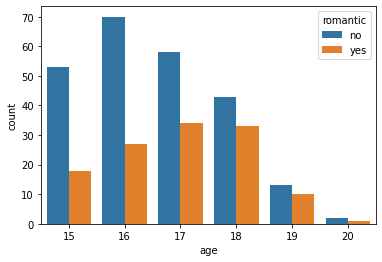

In [457]:
display(round((stud.romantic.value_counts(normalize=True, dropna=False)), 2))

sns.countplot(x='age', hue='romantic', data=stud)

По большей части (61%) учащиеся не состоят в отношениях. Чем старше возраст, тем выше количество учеников в отношениях.  
Отсутствующих значений 7%.

In [458]:
stud.romantic = stud.romantic.apply(lambda x: 'no' if pd.isnull(x) else x)
display(round((stud.romantic.value_counts(normalize=True, dropna=False)), 2))

no     0.69
yes    0.31
Name: romantic, dtype: float64

### 24. famrel (семейные отношения (от 1 - очень плохо до 5 - очень хорошо))

In [459]:
display(round((stud.famrel.value_counts(normalize=True, dropna=False)), 2))

 4.0    0.47
 5.0    0.25
 3.0    0.16
 NaN    0.07
 2.0    0.04
 1.0    0.02
-1.0    0.00
Name: famrel, dtype: float64

У большей части учеников хорошие отношения в семье.   
Есть 1 ошибочное значение, которое не попадает в заданный оценочный интервал, 27 пропущенных значений или 7%.

In [460]:
stud.famrel = np.where(stud.famrel == -1.0,
                       1.0,
                       stud.famrel)
display(round((stud.famrel.value_counts(dropna=False)), 2))

4.0    182
5.0     96
3.0     61
NaN     27
2.0     17
1.0      8
Name: famrel, dtype: int64

При различных группировках выявлены различные модальные значения, заменим ими отсусттвующие значения.

In [461]:
famrel_mode = stud.famrel.mode()[0]

stud.famrel = np.where(((stud.age == 19) | (stud.age == 16)) & (stud.famrel.isnull()),
                       famrel_mode,
                       stud.famrel)

In [462]:
famrel_mode_abs = 5.0

stud.famrel = np.where(((stud.absences == 1.0) | (stud.absences == 9.0) | (stud.absences == 13.0)) & (stud.famrel.isnull()),
                       famrel_mode_abs,
                       stud.famrel)

stud.famrel = np.where(stud.famrel.isnull(),
                       famrel_mode,
                       stud.famrel)

display(round((stud.famrel.value_counts(normalize=True, dropna=False)), 2))

4.0    0.53
5.0    0.25
3.0    0.16
2.0    0.04
1.0    0.02
Name: famrel, dtype: float64

### 25. freetime (свободное время после школы (от 1 - очень мало до 5 - очень мого))

In [463]:
display(round((stud.freetime.value_counts(normalize=True, dropna=False)), 2))
print(f'среднее значение {round(stud.freetime.mean())}')
print(f'модальное значение {round(stud.freetime.mode()[0])}')

3.0    0.39
4.0    0.28
2.0    0.16
5.0    0.09
1.0    0.04
NaN    0.03
Name: freetime, dtype: float64

среднее значение 3
модальное значение 3


Большинство учеников отметили среднее и высокое количество свободного времени после школы.  
Количество пропущенных значений 3%, их можно заменить на модальное (в данном случае оно совпадает со средним значением).

In [464]:
mode_ft = stud.freetime.mode()[0]
stud.freetime = stud.freetime.apply(lambda x: mode_ft if pd.isnull(x) else x)
display(round((stud.freetime.value_counts(normalize=True, dropna=False)), 2))

3.0    0.42
4.0    0.28
2.0    0.16
5.0    0.09
1.0    0.04
Name: freetime, dtype: float64

### 26. goout (проведение времени с друзьями (от 1 - очень мало до 5 - очень много))

In [465]:
display(round((stud.goout.value_counts(normalize=True, dropna=False)), 2))
print(f'среднее значение {round(stud.goout.mean())}')
print(f'модальное значение {round(stud.goout.mode()[0])}')

3.0    0.32
2.0    0.26
4.0    0.21
5.0    0.13
1.0    0.06
NaN    0.02
Name: goout, dtype: float64

среднее значение 3
модальное значение 3


In [466]:
mode_goout = stud.goout.mode()[0]
stud.goout = stud.goout.apply(lambda x: mode_goout if pd.isnull(x) else x)
display(round((stud.goout.value_counts(normalize=True, dropna=False)), 2))

3.0    0.34
2.0    0.26
4.0    0.21
5.0    0.13
1.0    0.06
Name: goout, dtype: float64

In [467]:
display(round((stud.groupby(['freetime'])['goout'].value_counts(
    normalize=True, dropna=False)), 2))

freetime  goout
1.0       2.0      0.35
          3.0      0.29
          1.0      0.24
          4.0      0.06
          5.0      0.06
2.0       2.0      0.41
          3.0      0.27
          4.0      0.17
          1.0      0.08
          5.0      0.06
3.0       3.0      0.45
          2.0      0.26
          4.0      0.16
          5.0      0.09
          1.0      0.04
4.0       4.0      0.35
          3.0      0.31
          2.0      0.16
          5.0      0.15
          1.0      0.04
5.0       5.0      0.43
          2.0      0.19
          4.0      0.16
          1.0      0.11
          3.0      0.11
Name: goout, dtype: float64

Оценка свободного времени и модального времени проведенного с друзьями совпадает практически по всем группам, из чего можно сделать вывод, что свободное после школы время ученики чаще всего проводят с друзьями.  
Отсутвующие значения составляли 2%, заменены на модальные.

### 27. health  (текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо))

In [468]:
display(round((stud.health.value_counts(normalize=True, dropna=False)), 2))
print(f'среднее значение {round(stud.health.mean())}')
print(f'модальное значение {round(stud.health.mode()[0])}')

5.0    0.35
3.0    0.23
4.0    0.16
1.0    0.12
2.0    0.11
NaN    0.04
Name: health, dtype: float64

среднее значение 4
модальное значение 5


In [469]:
mean_health = 4.0
stud.health = stud.health.apply(lambda x: mean_health if pd.isnull(x) else x)
display(round((stud.health.value_counts(normalize=True, dropna=False)), 2))

5.0    0.35
3.0    0.23
4.0    0.20
1.0    0.12
2.0    0.11
Name: health, dtype: float64

Большинство учеников оценивают текущее состояние здаровья как очень хорошее (35%) или среднее (23%).  
Данные содержали 4% пропусков, которые были заменены на среднее значение.

### 28. absences (количество пропущенных занятий)

In [470]:
display(round((stud.absences.value_counts(dropna=False)), 3))
print(f'среднее значение {round(stud.absences.mean())}')
print(f'модальное значение {round(stud.absences.mode()[0])}')

0.0      111
2.0       59
4.0       53
6.0       30
8.0       21
10.0      17
12.0      12
NaN       12
14.0      12
3.0        7
16.0       6
7.0        6
5.0        5
18.0       5
20.0       4
1.0        3
22.0       3
9.0        3
13.0       2
15.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64

среднее значение 7
модальное значение 0


<AxesSubplot:title={'center':'Количество пропущенных занятий'}>

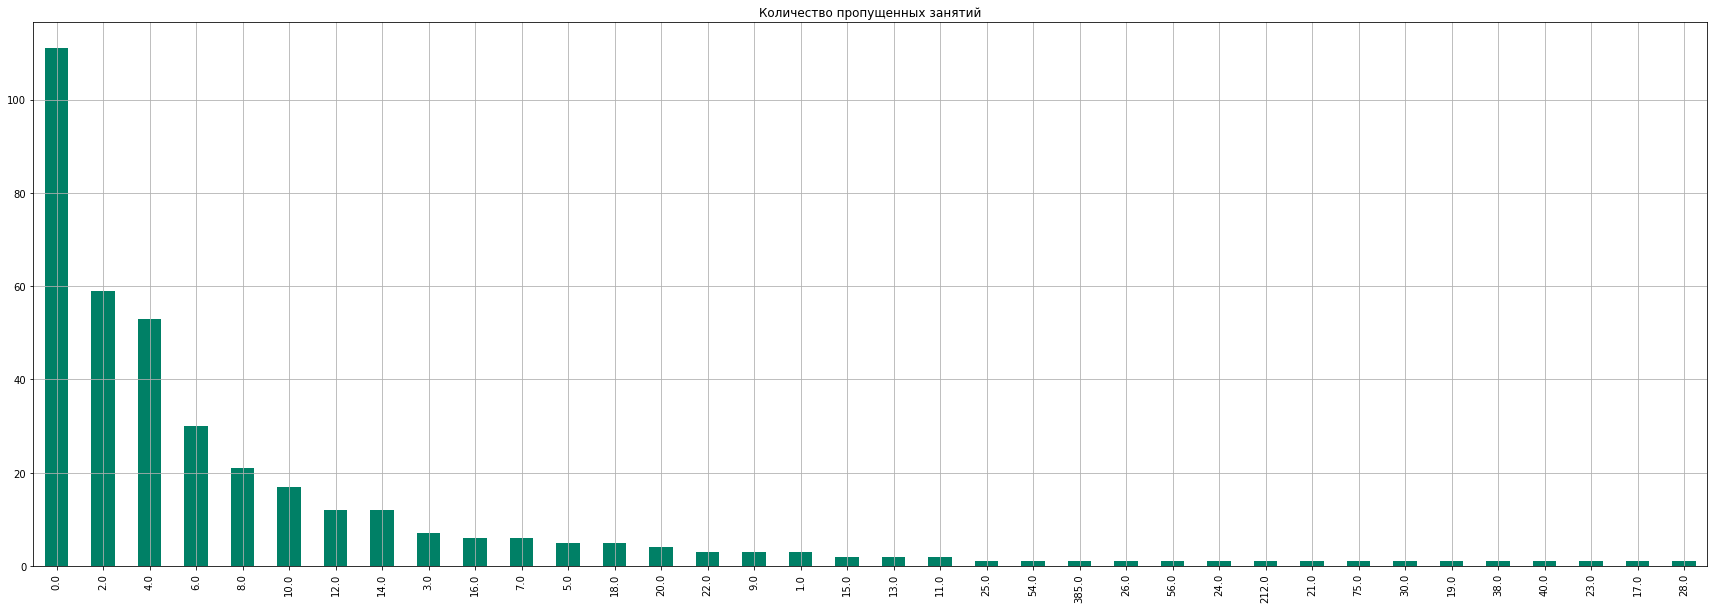

In [471]:
plt.figure(figsize=(30,10))

stud.absences.value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'summer', 
                              title = 'Количество пропущенных занятий')

Большинство учеников не имеют пропусков занятий.  
Отсутствующие значения в количестве 12 штук заменены на среднее значение.
Есть очень большие значения пропусков, проверим на выбросы.

In [472]:
value = stud.absences
IQR = value.quantile(0.75) - value.quantile(0.25)
perc25 = value.quantile(0.25)
perc75 = value.quantile(0.75)

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


In [473]:
round(((stud[stud['absences'] > 20.0].sort_values(
    'absences').shape[0])/stud.shape[0]), 3)

0.043

Количество строк, которые содержая выбросы по количеству прогулов составляет 3%.  
Поскольку данный показатель может оказывать влияние на итоговые значения экзамена по математике, преобразуем выбросы.

In [474]:
stud = stud.copy()
mean_bad = 7.0

stud.absences = np.where(stud['absences'] > 20.0,
                         mean_bad,
                         stud.absences)

stud.absences = stud.absences.apply(lambda x: mean_bad if pd.isnull(x) else x)


display(round((stud.absences.value_counts(dropna=False)), 3))

0.0     111
2.0      59
4.0      53
7.0      35
6.0      30
8.0      21
10.0     17
12.0     12
14.0     12
3.0       7
16.0      6
18.0      5
5.0       5
20.0      4
1.0       3
9.0       3
11.0      2
13.0      2
15.0      2
19.0      1
17.0      1
Name: absences, dtype: int64

Таким образом сохранены все данные, отсутствующие значения и выбросы преобразованы.

### 29. studytime, granular

Данные, полученные на основе гранулярных вычислений. Такие данные используются для машинного обучения, метод. которым они были почены не известен.

In [475]:
stud.columns = ['studytime_granular' if x ==
                'studytime, granular' else x for x in stud.columns]

stud.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,T,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,no,no,yes,-6.0,yes,yes,no,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,other,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [476]:
display(round((stud.studytime_granular.value_counts(dropna=False)), 3))
print(f'среднее значение {round(stud.studytime_granular.mean())}')
print(f'модальное значение {round(stud.studytime_granular.mode()[0])}')

-6.0     194
-3.0     101
-9.0      64
-12.0     27
 NaN       5
Name: studytime_granular, dtype: int64

среднее значение -6
модальное значение -6


In [477]:
stud = stud.copy()
mode_stg = stud.studytime_granular.mode()[0]

stud.studytime_granular = stud.studytime_granular.apply(
    lambda x: mode_stg if pd.isnull(x) else x)
display(round((stud.studytime_granular.value_counts(dropna=False)), 3))

-6.0     199
-3.0     101
-9.0      64
-12.0     27
Name: studytime_granular, dtype: int64

In [478]:
display(round((stud.groupby(['studytime'])['studytime_granular'].value_counts(
    normalize=True, dropna=False)), 2))

studytime  studytime_granular
1.0        -3.0                  1.0
2.0        -6.0                  1.0
3.0        -9.0                  1.0
4.0        -12.0                 1.0
Name: studytime_granular, dtype: float64

Судя по распределению к колонке studytime применен коэффициент -3 для полчения гранулярных вычислений.

### 30. score (баллы по госэкзамену по математике)

Предсказуемая величина

In [479]:
display(round((stud.score.value_counts(normalize=True, dropna=False)), 3))

print(f'среднее значение {round(stud.score.mean())}')
print(f'модальное значение {round(stud.score.mode()[0])}')

value = stud.score
IQR = value.quantile(0.75) - value.quantile(0.25)
perc25 = value.quantile(0.25)
perc75 = value.quantile(0.75)

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

50.0     0.136
55.0     0.118
0.0      0.095
75.0     0.084
60.0     0.079
65.0     0.077
40.0     0.077
45.0     0.069
70.0     0.069
80.0     0.041
30.0     0.038
90.0     0.031
35.0     0.020
25.0     0.018
NaN      0.015
85.0     0.015
95.0     0.013
100.0    0.003
20.0     0.003
Name: score, dtype: float64

среднее значение 52
модальное значение 50
25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


Большинство учеников получили средний балл по математике: 50 баллов 15,1%, 55 баллов 11,8%.  
Не сдали экзамен 9,5% учеников, эти данные являются выбросом, удалим их. 
Отсутствующих значений 1,5%, заменим их на модальное, поскольку среднее значение 52 балла отсутствует в представленных данных.  

In [480]:
stud_score_negative = stud[stud['score'] < 1.25]
stud = stud.drop(stud_score_negative.index, axis=0)

stud.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 0 to 394
Columns: 30 entries, school to score
dtypes: float64(11), int64(1), object(18)
memory usage: 85.7+ KB


In [481]:
stud = stud.copy()

mode_score = stud.score.mode()[0]
stud.score = stud.score.apply(
    lambda x: mode_score if pd.isnull(x) else x)

display(round((stud.score.value_counts(normalize=True, dropna=False)), 3))

50.0     0.167
55.0     0.130
75.0     0.093
60.0     0.088
65.0     0.085
40.0     0.085
70.0     0.076
45.0     0.076
80.0     0.045
30.0     0.042
90.0     0.034
35.0     0.023
25.0     0.020
85.0     0.017
95.0     0.014
100.0    0.003
20.0     0.003
Name: score, dtype: float64

После всех преобразований фрейм данных содержит 354 строки.

## Корреляционный анализ

До применения корреляционных методов, изменим тип переменных, которые фактически являются номинативными.

In [482]:
stud[['Medu', 'traveltime', 'studytime', 'failures', 'freetime', 'goout', 'health']] = stud[[
    'Medu', 'traveltime', 'studytime', 'failures', 'freetime', 'goout', 'health']].astype('object')

Проведем корреляционный анализ числовых переменных.

<AxesSubplot:>

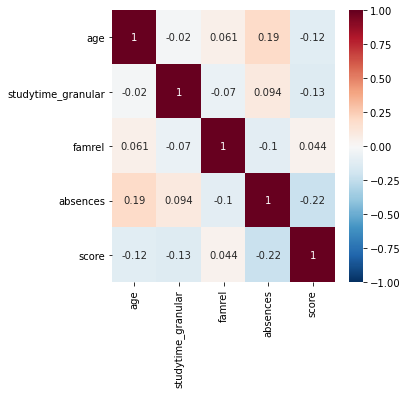

In [483]:
stud_corr = stud.corr()
plt.figure(figsize=(5, 5))
sns.heatmap(stud_corr, cmap=sns.color_palette(
    "RdBu_r", 1000), vmin=-1, center=0, annot=True)

In [484]:
round((stud.corr()['score'].sort_values()), 3)

absences             -0.224
studytime_granular   -0.130
age                  -0.117
famrel                0.044
score                 1.000
Name: score, dtype: float64

График показывает, что сильного влияния переменные друг на друга не оказывают.  
Только у количества пропущенных занятий прямая зависимость от итоговой оценки.

## Анализ номинативных переменных

In [485]:
stud_nomin = stud.select_dtypes(include = 'object')
stud_list = stud.columns.tolist()
stud_list

['school',
 'sex',
 'age',
 'address',
 'famsize',
 'Pstatus',
 'Medu',
 'Fedu',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'traveltime',
 'studytime',
 'failures',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'studytime_granular',
 'higher',
 'internet',
 'romantic',
 'famrel',
 'freetime',
 'goout',
 'health',
 'absences',
 'score']

В итоге в датафрейте 26 номинативных переменных.

In [486]:
def stud_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 3))
    sns.boxplot(x=column, y='score',
                data=stud.loc[stud.loc[:, column].isin(
                    stud.loc[:, column].value_counts().index[:20])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

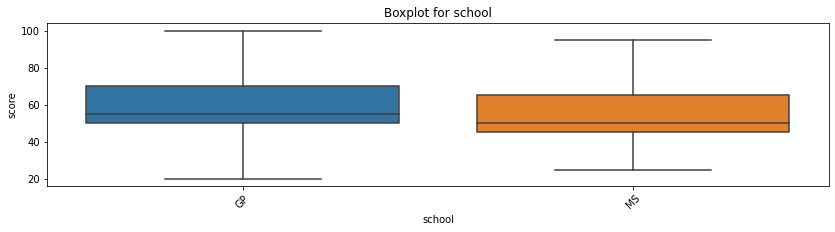

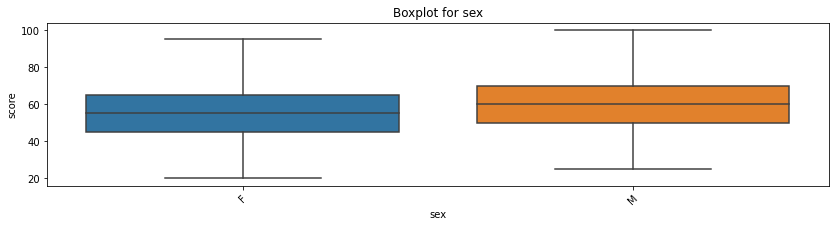

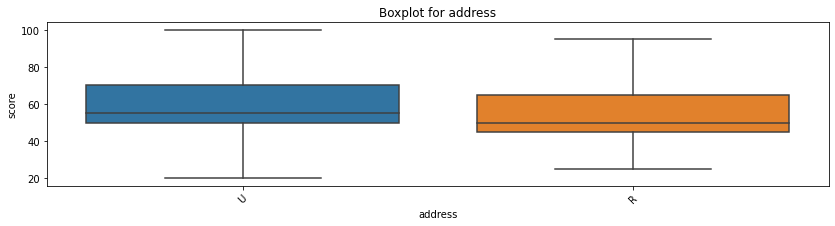

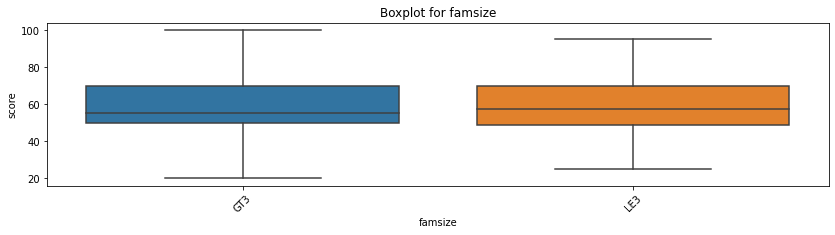

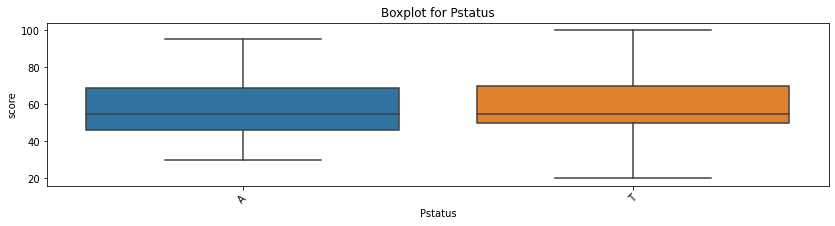

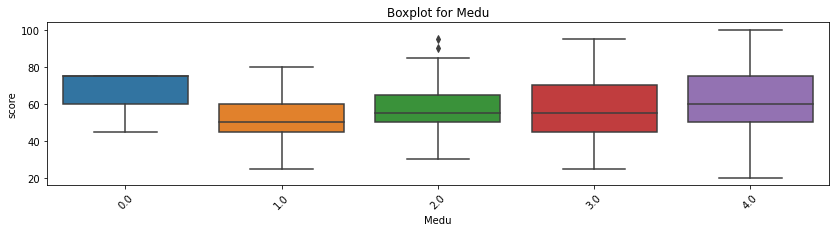

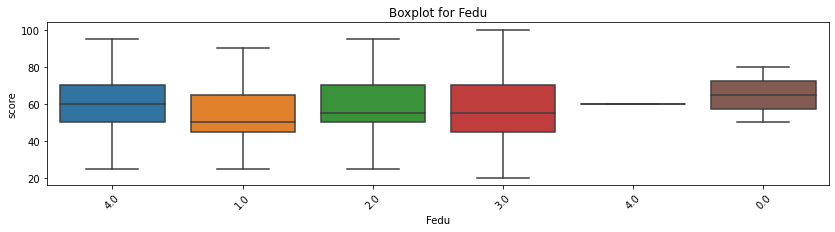

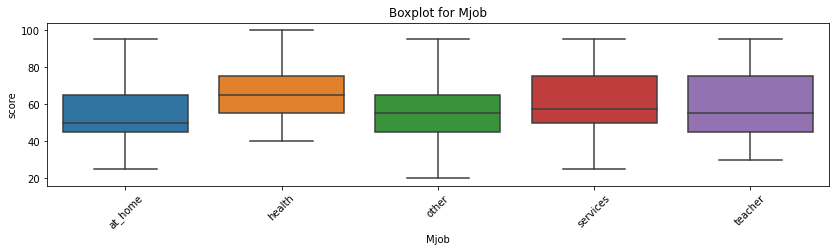

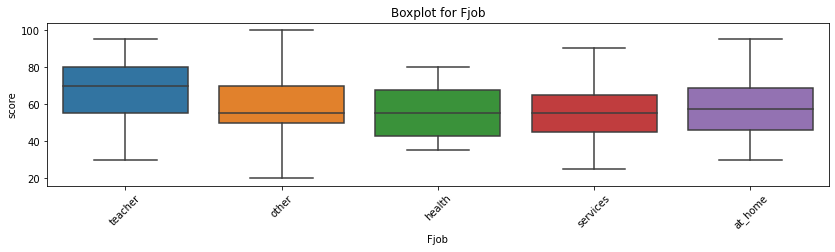

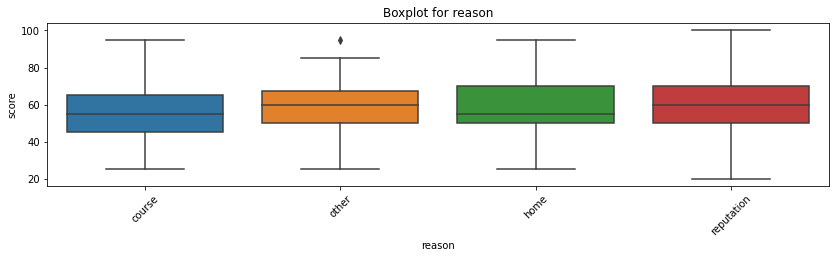

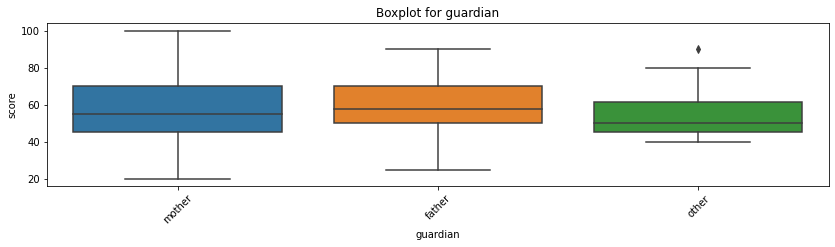

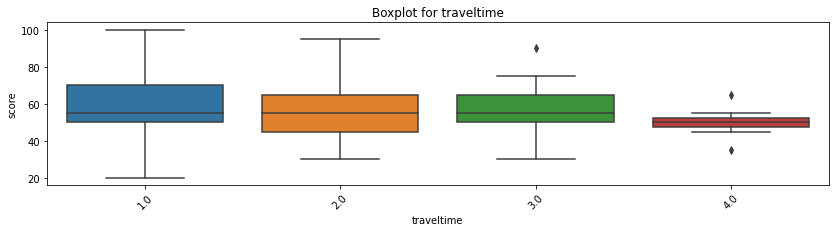

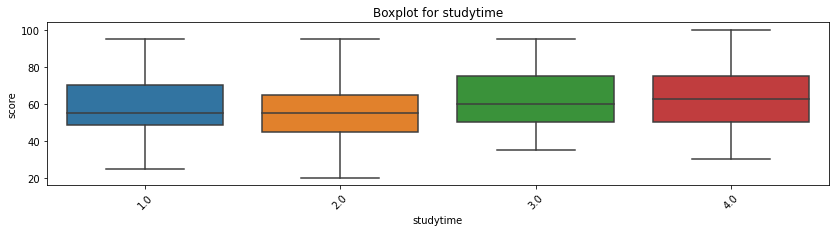

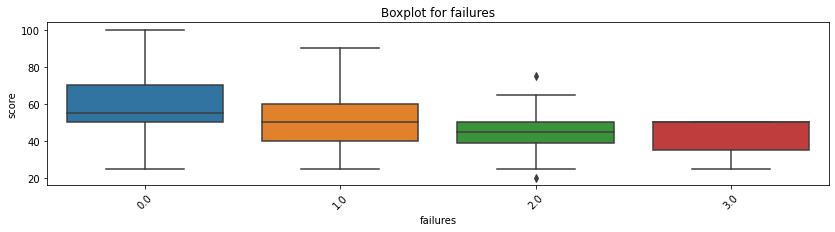

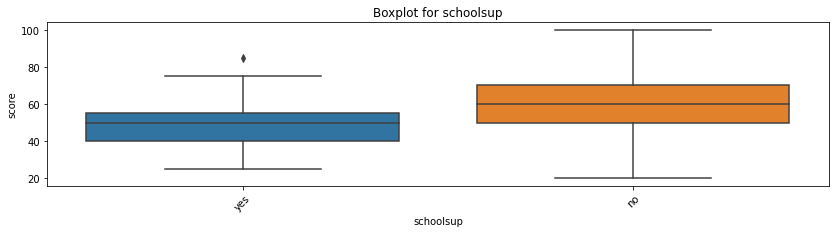

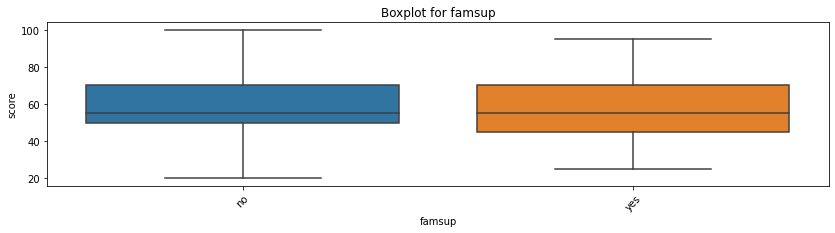

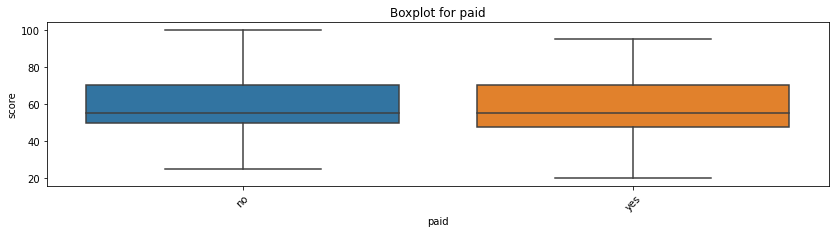

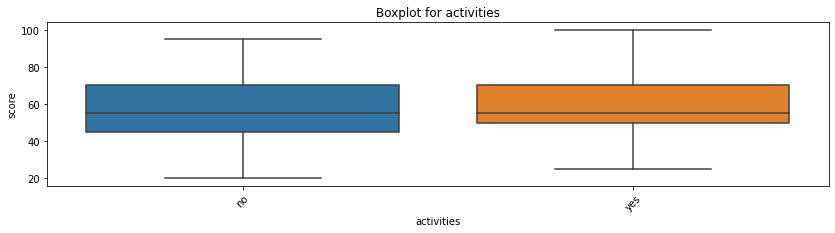

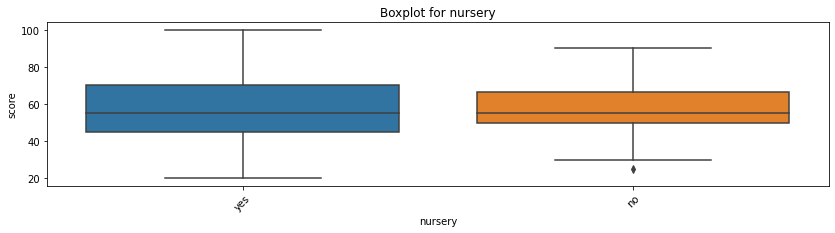

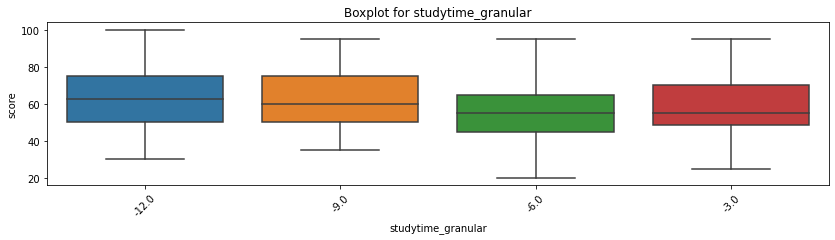

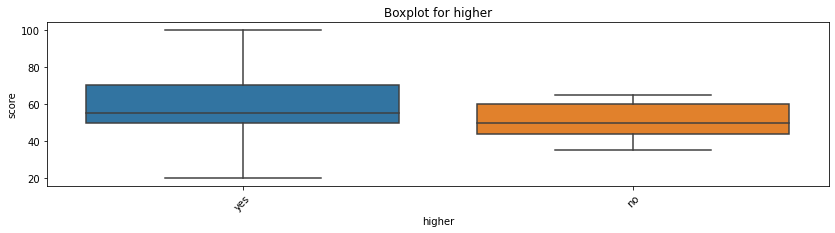

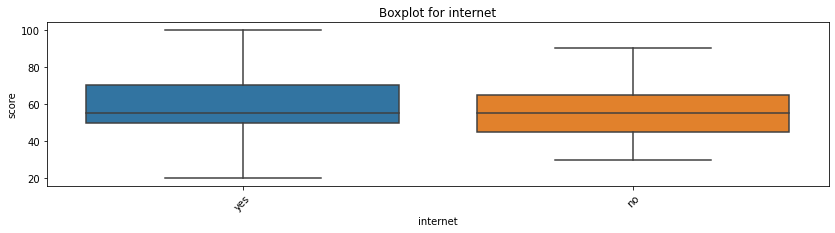

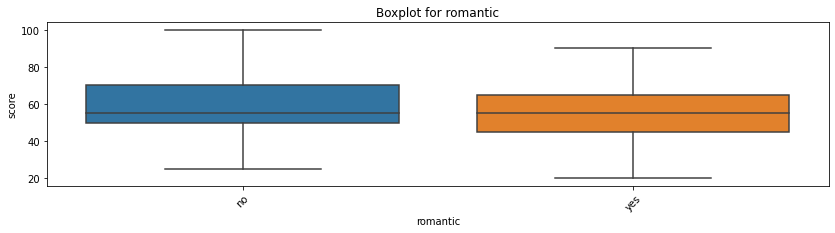

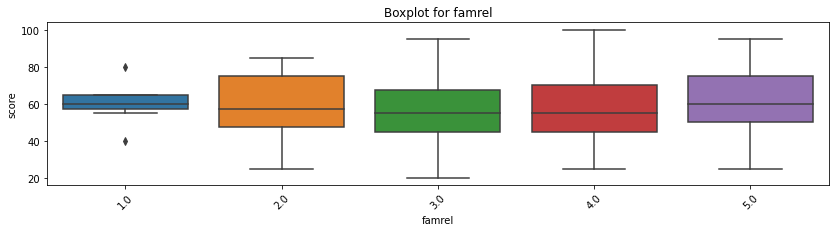

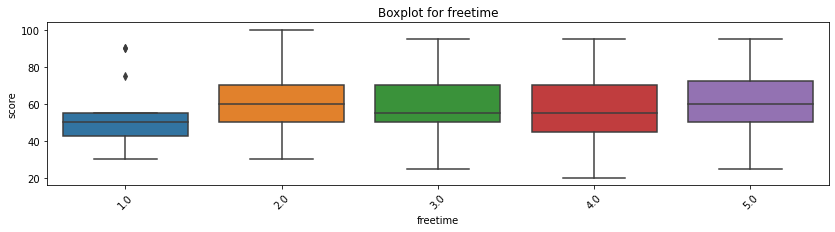

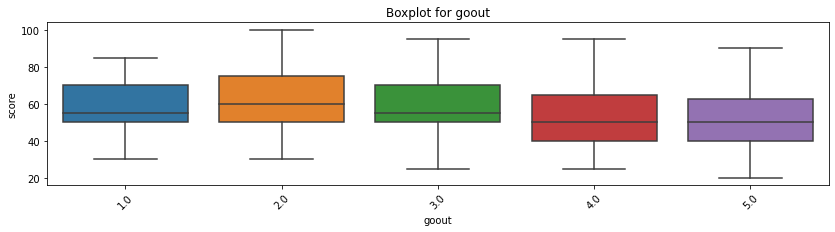

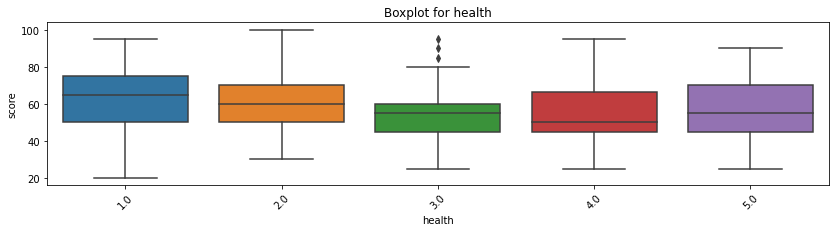

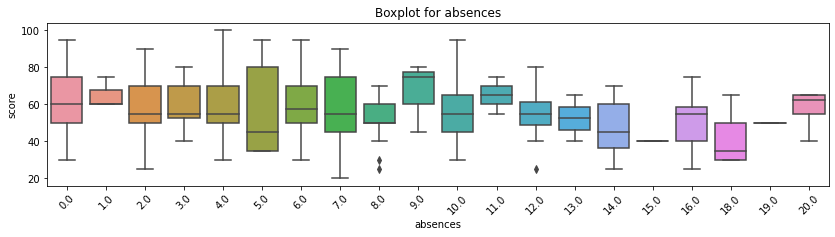

In [487]:
stud_list.remove('age')
stud_list.remove('score')
for col in stud_list:
    stud_boxplot(col)

На основании боксплотов для статистических тестов можно отобрать следующие переменные:  
 'Medu',    
 'Fedu',  
 'Mjob',  
 'Fjob',  
 'studytime',  
 'failures',  
 'schoolsup',  
 'studytime_granular',  
 'higher',  
 'famrel',  
 'freetime',  
 'goout',  
 'health',  
 'absences'   

In [488]:
def stud_stat_dif(column):
    cols = stud.loc[:, column].value_counts().index[:20]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud.loc[stud.loc[:, column] == comb[0], 'score'],
                     stud.loc[stud.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):
            print('Найдены статистически значимые различия для колонки', column)
            break

In [489]:
for col in ['Medu', 'Fedu', 'Mjob', 'Fjob', 'studytime', 'failures',
            'schoolsup', 'studytime_granular', 'higher', 'famrel', 'freetime', 'goout', 'health', 'absences']:
    stud_stat_dif(col)

Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки Fjob
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки studytime_granular
Найдены статистически значимые различия для колонки goout


C:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\anaconda\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\anaconda\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\anaconda\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret

Итак, в нашем случае важные переменные, которые, возможно, оказывают влияние на оценку, это: Medu, Mjob, Fjob, studytime, failures, schoolsup, studytime_granular, goout. 
  
Возможные трактования взаимосвязи:  
- Родители, у которых получено специальное (среднее или высшее) образование, обычно рекомендуют детям так же получить профессию. Экзамен по математике чаще всего сдается при поступлении в суз или вуз. В распределении у матерей больший процент высшего образования, соответственно и столбец "Medu" может оказывать влияние на итоговые оценки по математике.  
- Чаще всего родители пророчат детям работу по их специальности, соответственно "Mjob" и "Fjob" могут оказывать влияние на итоговые оценки по математике.  
- Наличие дополнительных занятий, репетиторства и наличие/отсутствие проигрышей в олимпиадах говорят о дополнительной или углубленной подготовке по школьным предметам, соответственно "studytime", "failures", "schoolsup", "studytime_granular" могут оказывать влияние на итоговые оценки по математике.  
- Окружение так же может оказывать влияние на успеваемость, соответственно "goout" так же может  оказывать влияние на итоговые оценки по математике.  

In [492]:
stud_for_model = stud.loc[:, ['absences', 'age', 'famrel', 'Medu', 'Mjob', 'Fjob', 'studytime', 
                              'failures', 'schoolsup', 'studytime_granular', 'goout', 'score']]
stud_for_model

,absences,age,famrel,Medu,Mjob,Fjob,studytime,failures,schoolsup,studytime_granular,goout,score
0,6.0,18,4.0,4,at_home,teacher,2,0,yes,-6.0,4,30.0
1,4.0,17,5.0,1,at_home,other,2,0,no,-6.0,3,30.0
2,10.0,15,4.0,1,at_home,other,2,3,yes,-6.0,2,50.0
3,2.0,15,3.0,4,health,other,3,0,no,-9.0,2,75.0
4,4.0,16,4.0,3,other,other,2,0,no,-6.0,2,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...
388,0.0,18,4.0,3,teacher,services,2,0,no,-6.0,4,40.0
390,7.0,20,5.0,2,services,services,2,2,no,-6.0,4,45.0
391,3.0,17,2.0,3,services,services,1,0,no,-3.0,5,80.0
393,0.0,18,4.0,3,services,other,1,0,no,-3.0,1,50.0


Фрейм данных для модели содержит 354 строки и 12 столбцов данных.

## Выводы

В результате EDA для анализа влияния условий жизни учащихся на успеваемость по математике были получены следующие выводы:  
- Большинство данных содержат отсутствующие значения в пределах 10% и были заменены на соответствующие модальные и средние значения.  Две строки были удалены по причине содержания большого количества отсутствующих данных.  
- Выбросы обнаружены в данных о возрасте "age", итоговых оценках "score" и количестве пропущенных занятий "absences" и были исключены.  
- Поскольку процент отсутствующих значений и выбросов не велик, можно сделать вывод, что данные доастаточно чистые.  

Параметры для будущей модели:  
'absences', 'age', 'famrel', 'Medu', 'Mjob', 'Fjob', 'studytime','failures', 'schoolsup', 'studytime_granular', 'goout', 'score'.  

Возможные трактования взаимосвязи:  
- Родители, у которых получено специальное (среднее или высшее) образование, обычно рекомендуют детям так же получить профессию. Экзамен по математике чаще всего сдается при поступлении в суз или вуз. В распределении у матерей больший процент высшего образования, соответственно и столбец "Medu" может оказывать влияние на итоговые оценки по математике.  
- Чаще всего родители пророчат детям работу по их специальности, соответственно "Mjob" и "Fjob" могут оказывать влияние на итоговые оценки по математике.  
- Наличие дополнительных занятий, репетиторства и наличие/отсутствие проигрышей в олимпиадах говорят о дополнительной или углубленной подготовке по школьным предметам, соответственно "studytime", "failures", "schoolsup", "studytime_granular" могут оказывать влияние на итоговые оценки по математике.  
- Окружение так же может оказывать влияние на успеваемость, соответственно "goout" так же может  оказывать влияние на итоговые оценки по математике. 
- количество пропущенных занятий может влиять на качество усвоения учебного материала, соответтсвенно 'absences'может  оказывать влияние на итоговые оценки по математике.
- От возраста зависит нагрузка учебной программы и отношение к учебе, по-этому параметр 'age'может  оказывать влияние на итоговые оценки по математике.  
- семейные отношения так же не редко оказывают влияние на успеваемость, особенно в более младшем возрасте, параметр 'famrel'может  оказывать влияние на итоговые оценки по математике.   